# Sentiment Analysis with Transformers
## By Erin Gregoire & Dawson Damuth
### June 2025

In [146]:
import pandas as pd

train_data = pd.read_csv("train_p4.csv", header=None)
test_data = pd.read_csv("test_p4.csv", header=None)

In [147]:
print("Train set shape:", train_data.shape)
print("Test set shape:", test_data.shape)

combined_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

combined_data.columns = ['Rating', 'Short Desc.', 'Review']

print("Combined set shape:", combined_data.shape)
combined_data.head()

Train set shape: (3000000, 3)
Test set shape: (650000, 3)
Combined set shape: (3650000, 3)


,Rating,Short Desc.,Review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [148]:
print(combined_data.info())
print(combined_data.describe(include='all'))
print(combined_data['Rating'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650000 entries, 0 to 3649999
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Rating       int64 
 1   Short Desc.  object
 2   Review       object
dtypes: int64(1), object(2)
memory usage: 83.5+ MB
None
              Rating   Short Desc.  \
count   3.650000e+06       3649786   
unique           NaN       2707765   
top              NaN  Disappointed   
freq             NaN         10012   
mean    3.000000e+00           NaN   
std     1.414214e+00           NaN   
min     1.000000e+00           NaN   
25%     2.000000e+00           NaN   
50%     3.000000e+00           NaN   
75%     4.000000e+00           NaN   
max     5.000000e+00           NaN   

                                                   Review  
count                                             3650000  
unique                                            3645844  
top     For some inexplicable reason, Amazon has remov...  
freq      

In [149]:
import numpy as np

combined_data_mc = combined_data.copy()

combined_data = combined_data[combined_data['Rating'] != 3]
combined_data['sentiment'] = np.where(combined_data['Rating'] <= 2, 0, 1)


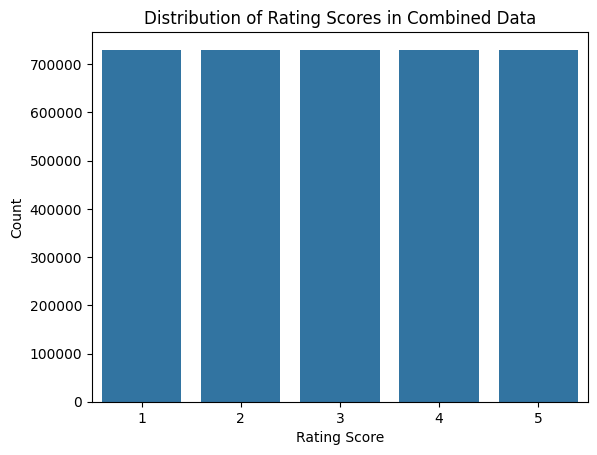

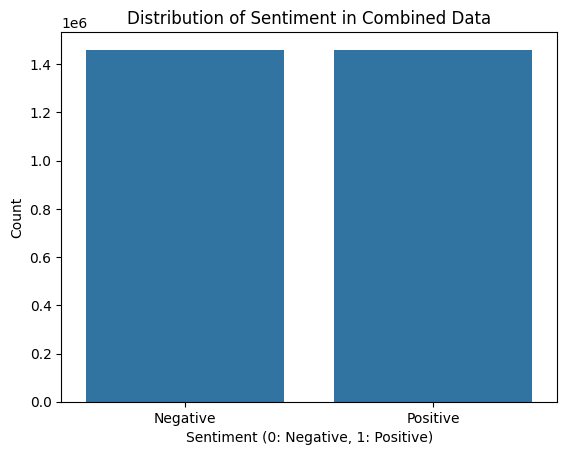

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=combined_data_mc['Rating'])
plt.title("Distribution of Rating Scores in Combined Data")
plt.xlabel("Rating Score")
plt.ylabel("Count")
plt.show()

sns.countplot(x=combined_data['sentiment'])
plt.title("Distribution of Sentiment in Combined Data")
plt.xlabel("Sentiment (0: Negative, 1: Positive)")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.ylabel("Count")
plt.show()

The above plots show the even distribution in our data across all class values. Note that the second plot displays only two classes, 'Positive' and 'Negative'. These classes are classified by ratings of 1 and 2 being considered 'Negative', with 4 and 5 ratings being considered 'Positive'. We chose to omit the rating of 3 in this binarization because of the ambiguity of the rating, making it difficult to decipher in most cases which class the review would belong to and is seen more as a 'Neutral' class on it's own.

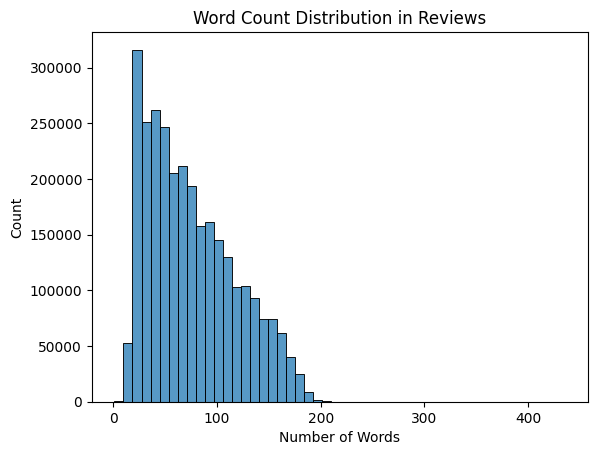

In [151]:
combined_data['word_count'] = combined_data['Review'].apply(lambda x: len(str(x).split()))
sns.histplot(combined_data['word_count'], bins=50)
plt.title("Word Count Distribution in Reviews")
plt.xlabel("Number of Words")
plt.show()

The above histogram displays the total number of words in our reviews and the frequency of that word count. We can see most of our reviews are somewhere between 20 and 175 words, with much lower frequencies outside of that range.

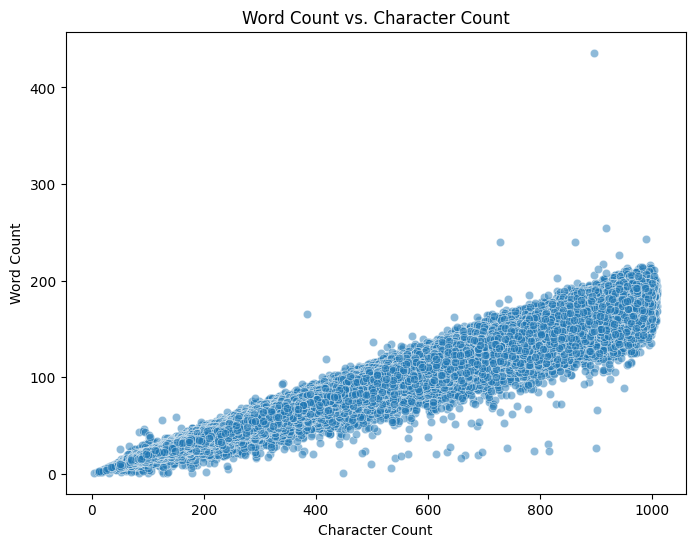

In [152]:
combined_data['char_count'] = combined_data['Review'].apply(len)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_data, x='char_count', y='word_count', alpha=0.5)
plt.title("Word Count vs. Character Count")
plt.xlabel("Character Count")
plt.ylabel("Word Count")
plt.show()

Our final plot displays the correlation between word count and character count in our reviews. This can help us gain insight to the uniformity of the reviews, whereas some reviews may contain unintelligable blurbs of letters, links, or things of the sort which may cause trouble for our model.

In [153]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

combined_data['clean_review'] = combined_data['Review'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dadamuth2302/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Before we tokenize, we will randomly sample to a tenth of the binary dataset size, resulting in a full datset of 292,000.

In [154]:
sampled_data = combined_data.sample(frac=0.1, random_state=676)

sampled_data = sampled_data.reset_index(drop=True)

print("Sampled data shape:", sampled_data.shape)
sampled_data.head()

Sampled data shape: (292000, 7)


,Rating,Short Desc.,Review,sentiment,word_count,char_count,clean_review
0,4,Great creative play toy,My three year old loves the tools on this belt...,1,45,272,three year old loves tools beltwe havent probl...
1,1,Absolutely useless,This product is terrible. My polish chipped fa...,0,21,119,product terrible polish chipped faster would w...
2,1,"Adorable, but immediately broke","I'm a loyal Fedex customer, and my son loves t...",0,30,166,im loyal fedex customer son loves trucks bough...
3,4,trim installers kit,"Great little tool, using it all the time for m...",1,35,192,great little tool using time home projectsthe ...
4,4,What happens when a lover is paralyzed,What happens when a lover is paralyzedI have t...,1,129,707,happens lover paralyzedi two friends married p...


In [155]:
import time
from gensim.utils import simple_preprocess

data = sampled_data.copy()

gensim_start = time.time()
data['gensim tokens'] = data['clean_review'].apply(lambda x: simple_preprocess(str(x), deacc=True))
gensim_end = time.time()
gensim_time = gensim_end - gensim_start
print('Gensim Processing Time:', round(gensim_time/60), 'minutes')

vocab_gensim = [i for row in data['gensim tokens'] for i in row]
vocab_unique_gensim = set(vocab_gensim)
print('Gensim Vocabulary size:', len(vocab_unique_gensim), 'words')

Gensim Processing Time: 0 minutes
Gensim Vocabulary size: 341963 words


In [156]:
print(data['gensim tokens'].head())

0    [three, year, old, loves, tools, beltwe, haven...
1    [product, terrible, polish, chipped, faster, w...
2    [im, loyal, fedex, customer, son, loves, truck...
3    [great, little, tool, using, time, home, proje...
4    [happens, lover, paralyzedi, two, friends, mar...
Name: gensim tokens, dtype: object


In [157]:
from collections import Counter

vocab_counted = Counter(vocab_gensim)

vocab = {}
for token in vocab_counted:
    vocab[token] = len(vocab)

In [158]:
def tok2indx(tokens, vocab):
    return [vocab.get(token) for token in tokens]

In [159]:
data['vocab index'] = data['gensim tokens'].apply(lambda x: tok2indx(x, vocab))

In [160]:
data.head()

,Rating,Short Desc.,Review,sentiment,word_count,char_count,clean_review,gensim tokens,vocab index
0,4,Great creative play toy,My three year old loves the tools on this belt...,1,45,272,three year old loves tools beltwe havent probl...,"[three, year, old, loves, tools, beltwe, haven...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,1,Absolutely useless,This product is terrible. My polish chipped fa...,0,21,119,product terrible polish chipped faster would w...,"[product, terrible, polish, chipped, faster, w...","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]"
2,1,"Adorable, but immediately broke","I'm a loyal Fedex customer, and my son loves t...",0,30,166,im loyal fedex customer son loves trucks bough...,"[im, loyal, fedex, customer, son, loves, truck...","[36, 37, 38, 39, 40, 3, 41, 42, 43, 44, 45, 46..."
3,4,trim installers kit,"Great little tool, using it all the time for m...",1,35,192,great little tool using time home projectsthe ...,"[great, little, tool, using, time, home, proje...","[23, 14, 53, 54, 55, 56, 57, 58, 59, 60, 61, 1..."
4,4,What happens when a lover is paralyzed,What happens when a lover is paralyzedI have t...,1,129,707,happens lover paralyzedi two friends married p...,"[happens, lover, paralyzedi, two, friends, mar...","[72, 73, 74, 44, 75, 76, 77, 78, 79, 80, 81, 8..."


In [161]:
data_new = data.drop(columns=['Rating', 'Review', 'Short Desc.', 'gensim tokens', 'word_count', 'char_count', 'clean_review'])

In [162]:
data_new.to_csv('p4_data_cleaned.csv', index=False)

Save data to csv and reload for convenience.

In [11]:
data.head()

,sentiment,vocab index
0,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,0,"[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]"
2,0,"[36, 37, 38, 39, 40, 3, 41, 42, 43, 44, 45, 46..."
3,1,"[23, 14, 53, 54, 55, 56, 57, 58, 59, 60, 61, 1..."
4,1,"[72, 73, 74, 44, 75, 76, 77, 78, 79, 80, 81, 8..."


In [11]:
data['vocab index'] = data['vocab index'].apply(json.loads)

In [12]:
lengths = data['vocab index'].apply(len)
percentile_95 = int(np.percentile(lengths, 95))
print('95th percentile will be used to pad/truncate our review lengths:', percentile_95)

95th percentile will be used to pad/truncate our review lengths: 79


In [13]:
data_padded = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(seq) for seq in data['vocab index']], batch_first=True)

In [14]:
X = data_padded
y = data.iloc[:, 0]
y_tensor = torch.tensor(y.values, dtype=torch.long)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y_tensor, test_size = .1, stratify=y, random_state=676)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = len(y_val), stratify=y_train, random_state=676)

In [16]:
print('X train:', X_train.shape, '| y train:', y_train.shape)
print('X validation:', X_val.shape, '| y validation:', y_val.shape)
print('X test:', X_test.shape, '| y test:', y_test.shape)

X train: torch.Size([233600, 166]) | y train: torch.Size([233600])
X validation: torch.Size([29200, 166]) | y validation: torch.Size([29200])
X test: torch.Size([29200, 166]) | y test: torch.Size([29200])


In [19]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

##### References

Dataset: "amazon_review_full_csv.tar.gz"

"NLTK Stop Words." Pythonspot, pythonspot.com/nltk-stop-words/. 

"NLP Gensim Tutorial - Complete Guide For Beginners." GeeksforGeeks, 7 Nov 2022, https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/. Accessed 15 June 2025.

PyTorch Contributors. "torch.nn.utils.rnn.pad_sequence." PyTorch, https://docs.pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html. Accessed 16 June 2025.